In [2]:
import sqlite3
import geopandas as gpd
import pandas as pd
import geobr
import matplotlib.pyplot as plt
import numpy as np
from shapely.wkt import loads as load_wkt
from shapely.geometry import Point
from shapely.ops import unary_union
from PIL import Image
import re
%matplotlib inline

from libpysal.weights.contiguity import Queen
import libpysal
import esda
from splot.esda import moran_scatterplot
from splot.esda import lisa_cluster

In [3]:
#declara documentos

indicadores_db = "bases\\indicadores.db"
pop2020_csv = "bases\\pop2020.csv"

In [4]:
#lê indicadores.db
cnx = sqlite3.connect(indicadores_db)

brazil_df = pd.read_sql_query("SELECT * FROM brazil_df", cnx)
region_df = pd.read_sql_query("SELECT * FROM regions_df", cnx)
states_df = pd.read_sql_query("SELECT * FROM states_df", cnx)
regimed_df = pd.read_sql_query("SELECT * FROM imedreg_df", cnx)
cities_df = pd.read_sql_query("SELECT * FROM cities_df", cnx)

In [5]:
#Leitura da geometrias das regiões e merge com os indicadores

ri_geometry = geobr.read_immediate_region()
ri_geometry = ri_geometry.rename(columns={'code_immediate':'imed_reg_code'})
ri_geometry['imed_reg_code'] = ri_geometry['imed_reg_code'].astype(int)
ri_geo = ri_geometry.merge(regimed_df, on = 'imed_reg_code')

/home/pedro/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [6]:
#ri_geometry       completo

In [7]:
#le cidades e salva coords
geometry_cities = geobr.read_municipality()
geometry_cities['code_muni'] = geometry_cities['code_muni'].astype('int64')
geometry_cities = geometry_cities.rename(columns={'code_muni':'city_ibge_code'})

#Cria uma cópia do dataframe para não persistir nenhuma alteração
geometry_cities = gpd.GeoDataFrame(geometry_cities)

#Cria uma nova coluna com as coordenadas do ponto representativo de cada cidade
geometry_cities['coords'] = geometry_cities['geometry'].apply(lambda x: x.representative_point().coords[:])
geometry_cities['coords'] = [coords[0] for coords in geometry_cities['coords']]

#lê pop2020
pop2020 = pd.read_csv(pop2020_csv)

# faz merge com a geometria
pop2020 = pop2020.rename(columns={'Armenor':'city_ibge_code'})
pop2020['city_ibge_code'] = pop2020['city_ibge_code'].astype('int64')
pop2020 = pd.merge(pop2020, geometry_cities, how='left', on='city_ibge_code')

#faz o merge com o cities_df
cities_df['city_ibge_code'] = cities_df['city_ibge_code'].astype('int64')
cities_df = pd.merge(cities_df, geometry_cities, how='left', on='city_ibge_code')

In [8]:
#pop2020           completo
#cities_df         completo
#geometry_cities   completo

In [9]:
#cria dataframe com cidades com mais de 100k habitantes
cidades100k = []

#adiciona à lista as cidades com mais de 100k habitantes
for i, cidade in pop2020.iterrows():
    if float(cidade['Total']) > 100000:
        cidades100k.append(cidade)
        
cidades100k = pd.DataFrame(cidades100k).reset_index()


#cria dataframe com cidades com mais de 1M habitantes
cidades1M = []

#adiciona à lista as cidades com mais de 1M habitantes
for i, cidade in cidades100k.iterrows():
    if float(cidade['Total']) > 1000000:
        cidades1M.append(cidade)
        
cidades1M = pd.DataFrame(cidades1M).reset_index()

In [10]:
#cidades100k     completo
#cidades1M       completo

In [11]:
#criar dataframe com regiões imediatas que contem cidades com mais de 100k
ri_geo100k = []

#confere se a coordenada de pelo menos uma das cidades com mais de 100k esta contida na geometria da região imediata
for i, ri in ri_geometry.iterrows():
    for cidade in cidades100k['coords']: 
        if Point(cidade).within(ri['geometry']):
            ri_geo100k.append(ri)
            break
            
#Cria uma cópia do dataframe para não persistir nenhuma alteração
ri_geo100k = gpd.GeoDataFrame(ri_geo100k)

#Cria uma nova coluna com as coordenadas do ponto representativo de cada região imediata
ri_geo100k['coords'] = ri_geo100k['geometry'].apply(lambda x: x.representative_point().coords[:])
ri_geo100k['coords'] = [coords[0] for coords in ri_geo100k['coords']]




#criar dataframe com regiões imediatas que contem cidades com mais de 1M
ri_geo1M = []

#confere se a coordenada de pelo menos uma das cidades com mais de 1M esta contida na geometria da região imediata
for i, ri in ri_geometry.iterrows():
    for cidade in cidades1M['coords']: 
        if Point(cidade).within(ri['geometry']):
            ri_geo1M.append(ri)
            break
            
#Cria uma cópia do dataframe para não persistir nenhuma alteração
ri_geo1M = gpd.GeoDataFrame(ri_geo1M)

#Cria uma nova coluna com as coordenadas do ponto representativo de cada região imediata
ri_geo1M['coords'] = ri_geo1M['geometry'].apply(lambda x: x.representative_point().coords[:])
ri_geo1M['coords'] = [coords[0] for coords in ri_geo1M['coords']]

In [12]:
#ri_geo100k      completo
#ri_geo1M        completo

In [13]:
#importa biblioteca dos pesos

from splot.libpysal import plot_spatial_weights

In [14]:
geometry_states = geobr.read_state()
#Cria uma cópia do dataframe para não persistir nenhuma alteração
geometry_states = gpd.GeoDataFrame(geometry_states)

#Cria uma nova coluna com as coordenadas do ponto representativo de cada macrorregião
geometry_states['coords'] = geometry_states['geometry'].apply(lambda x: x.representative_point().coords[:])
geometry_states['coords'] = [coords[0] for coords in geometry_states['coords']]

states_geo = gpd.GeoDataFrame(geometry_states)

/home/pedro/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [19]:
#geometry_states   completo
#states_geo        completo

In [23]:
#rodovias_geo     completo

/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

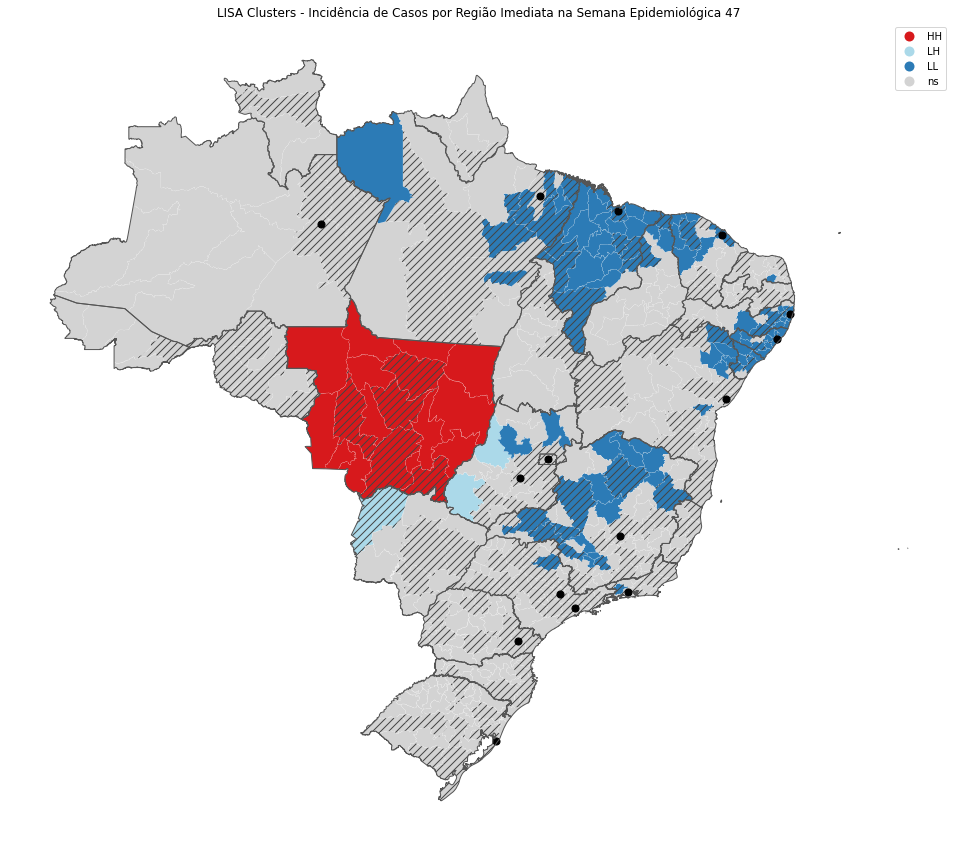

In [62]:
#kernel de teste para plotagens
for i in range(1):


    semana = 47


    #Alterar aqui para mudar a semana analisada
    sem = ri_geo[ri_geo['epidemiological_week'] == semana]
    str_sem = str(semana)

    #Trata valores negativos
    for element in sem['incidence_cases']:
        if element < 0:
            element = 0   

    weights = Queen.from_dataframe(sem)
    weights.transform = 'r'
    plot_spatial_weights(weights, sem)
    plt.close() 

    #Consertando os erros causados pela digitalização
    wnp = libpysal.weights.util.nonplanar_neighbors(weights, sem)
    wnp.transform = 'r'
    plot_spatial_weights(wnp, sem)
    plt.close()

    spatial_auto = esda.Moran_Local(sem['incidence_cases'], wnp, permutations=100000)
    moran = esda.Moran(sem['incidence_cases'], wnp)


    fig, ax = lisa_cluster(spatial_auto, sem, p=0.05, figsize = (20,15))

    states_geo.geometry.boundary.plot(color=None,edgecolor='#555555', linewidth = 1,ax=ax)

    #Pega as coordenadas das ri100k
    xs=[coordenada[0] for coordenada in ri_geo100k['coords']]
    ys=[coordenada[1] for coordenada in ri_geo100k['coords']]
    #scatter = ax.scatter(xs, ys, 50, marker='x',  alpha=0.6, color="#333333")
    #ri_geo100k.geometry.plot(color='#61d632', edgecolor=None, alpha=0.3, linewidth =0.5,ax=ax)
    ri_geo100k.geometry.plot(color='None', edgecolor='#444444', hatch='///', linewidth=0, ax=ax)

    #rodovias_geo.geometry.plot(color=None,edgecolor='#00AA00', linewidth = 1, ax=ax)
    
    #Pega as coordenadas das ri1M
    xs=[coordenada[0] for coordenada in ri_geo1M['coords']]
    ys=[coordenada[1] for coordenada in ri_geo1M['coords']]
    scatter = ax.scatter(xs, ys, 50, marker='o', color="#000000")

    plt.title('LISA Clusters - Incidência de Casos por Região Imediata na Semana Epidemiológica ' + str_sem)

    #plt.savefig(f'aaa{i}incidencia_de_casos_sem_{str_sem}.png', facecolor='w', dpi=120)
    plt.show()


In [1]:
## semanas: 13, 17, 22, 26, 34, 38, 42, 46, 50, 54

semanas = {46, 50, 54}

# Incidência

In [63]:
for semana in semanas:

    #Alterar aqui para mudar a semana analisada
    sem = ri_geo[ri_geo['epidemiological_week'] == semana]
    str_sem = str(semana)

    #Trata valores negativos
    for element in sem['incidence_cases']:
        if element < 0:
            element = 0   

    weights = Queen.from_dataframe(sem)
    weights.transform = 'r'
    plot_spatial_weights(weights, sem)
    plt.close() 

    #Consertando os erros causados pela digitalização
    wnp = libpysal.weights.util.nonplanar_neighbors(weights, sem)
    wnp.transform = 'r'
    plot_spatial_weights(wnp, sem)
    plt.close()

    spatial_auto = esda.Moran_Local(sem['incidence_cases'], wnp, permutations=100000)
    moran = esda.Moran(sem['incidence_cases'], wnp)


    fig, ax = lisa_cluster(spatial_auto, sem, p=0.05, figsize = (20,15))

    states_geo.geometry.boundary.plot(color=None,edgecolor='#555555', linewidth = 1,ax=ax)

    #Pega as coordenadas das ri100k
    xs=[coordenada[0] for coordenada in ri_geo100k['coords']]
    ys=[coordenada[1] for coordenada in ri_geo100k['coords']]
    #scatter = ax.scatter(xs, ys, 50, marker='x',  alpha=0.6, color="#333333")
    #ri_geo100k.geometry.plot(color='#61d632', edgecolor=None, alpha=0.3, linewidth =0.5,ax=ax)
    ri_geo100k.geometry.plot(color='None', edgecolor='#444444', hatch='///', linewidth=0, ax=ax)

    #rodovias_geo.geometry.plot(color=None,edgecolor='#00AA00', linewidth = 1, ax=ax)
    
    #Pega as coordenadas das ri1M
    xs=[coordenada[0] for coordenada in ri_geo1M['coords']]
    ys=[coordenada[1] for coordenada in ri_geo1M['coords']]
    scatter = ax.scatter(xs, ys, 50, marker='o', color="#000000")

    plt.title('LISA Clusters - Incidência de Casos por Região Imediata na Semana Epidemiológica ' + str_sem)

    plt.savefig(f'mapas\\wincidencia_de_casos_sem_{str_sem}.png', facecolor='w', dpi=120)
    plt.close()

/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

# Letalidade

In [64]:
for semana in semanas:

    #Alterar aqui para mudar a semana analisada
    sem = ri_geo[ri_geo['epidemiological_week'] == semana]
    str_sem = str(semana)

    #Trata valores negativos
    for element in sem['incidence_cases']:
        if element < 0:
            element = 0   

    weights = Queen.from_dataframe(sem)
    weights.transform = 'r'
    plot_spatial_weights(weights, sem)
    plt.close() 

    #Consertando os erros causados pela digitalização
    wnp = libpysal.weights.util.nonplanar_neighbors(weights, sem)
    wnp.transform = 'r'
    plot_spatial_weights(wnp, sem)
    plt.close()

    spatial_auto = esda.Moran_Local(sem['incidence_cases'], wnp, permutations=100000)
    moran = esda.Moran(sem['incidence_cases'], wnp)


    fig, ax = lisa_cluster(spatial_auto, sem, p=0.05, figsize = (20,15))

    states_geo.geometry.boundary.plot(color=None,edgecolor='#555555', linewidth = 1,ax=ax)

    #Pega as coordenadas das ri100k
    xs=[coordenada[0] for coordenada in ri_geo100k['coords']]
    ys=[coordenada[1] for coordenada in ri_geo100k['coords']]
    #scatter = ax.scatter(xs, ys, 50, marker='x',  alpha=0.6, color="#333333")
    #ri_geo100k.geometry.plot(color='#61d632', edgecolor=None, alpha=0.3, linewidth =0.5,ax=ax)
    ri_geo100k.geometry.plot(color='None', edgecolor='#444444', hatch='///', linewidth=0, ax=ax)

    #rodovias_geo.geometry.plot(color=None,edgecolor='#00AA00', linewidth = 1, ax=ax)
    
    #Pega as coordenadas das ri1M
    xs=[coordenada[0] for coordenada in ri_geo1M['coords']]
    ys=[coordenada[1] for coordenada in ri_geo1M['coords']]
    scatter = ax.scatter(xs, ys, 50, marker='o', color="#000000")

    plt.title('LISA Clusters - Letalidade por Região Imediata na Semana Epidemiológica ' + str_sem)

    plt.savefig(f'mapas\\wletalidade_sem_{str_sem}.png', facecolor='w', dpi=120)
    plt.close()

/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

# Prevalência

In [65]:
for semana in semanas:

    #Alterar aqui para mudar a semana analisada
    sem = ri_geo[ri_geo['epidemiological_week'] == semana]
    str_sem = str(semana)

    #Trata valores negativos
    for element in sem['incidence_cases']:
        if element < 0:
            element = 0   

    weights = Queen.from_dataframe(sem)
    weights.transform = 'r'
    plot_spatial_weights(weights, sem)
    plt.close() 

    #Consertando os erros causados pela digitalização
    wnp = libpysal.weights.util.nonplanar_neighbors(weights, sem)
    wnp.transform = 'r'
    plot_spatial_weights(wnp, sem)
    plt.close()

    spatial_auto = esda.Moran_Local(sem['incidence_cases'], wnp, permutations=100000)
    moran = esda.Moran(sem['incidence_cases'], wnp)


    fig, ax = lisa_cluster(spatial_auto, sem, p=0.05, figsize = (20,15))

    states_geo.geometry.boundary.plot(color=None,edgecolor='#555555', linewidth = 1,ax=ax)

    #Pega as coordenadas das ri100k
    xs=[coordenada[0] for coordenada in ri_geo100k['coords']]
    ys=[coordenada[1] for coordenada in ri_geo100k['coords']]
    #scatter = ax.scatter(xs, ys, 50, marker='x',  alpha=0.6, color="#333333")
    #ri_geo100k.geometry.plot(color='#61d632', edgecolor=None, alpha=0.3, linewidth =0.5,ax=ax)
    ri_geo100k.geometry.plot(color='None', edgecolor='#444444', hatch='///', linewidth=0, ax=ax)

    #rodovias_geo.geometry.plot(color=None,edgecolor='#00AA00', linewidth = 1, ax=ax)
    
    #Pega as coordenadas das ri1M
    xs=[coordenada[0] for coordenada in ri_geo1M['coords']]
    ys=[coordenada[1] for coordenada in ri_geo1M['coords']]
    scatter = ax.scatter(xs, ys, 50, marker='o', color="#000000")

    plt.title('LISA Clusters - Prevalência por Região Imediata na Semana Epidemiológica ' + str_sem)

    plt.savefig(f'mapas\\wprevalencia_sem_{str_sem}.png', facecolor='w', dpi=120)
    plt.close()

/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 4 islands with ids: 24, 30, 133, 169.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values


('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri

('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/home/pedro/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/pedro/anaconda3/lib/python3.8/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeri